In this notebook, we present various usecases to interact with ptype for column type predictions.

In [50]:
# Preamble to run notebook in context of source package.
# NBVAL_IGNORE_OUTPUT
import sys
sys.path.insert(0, '../')

In [51]:
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcdefaults()
import numpy as np
import pandas as pd
# import pprint
import seaborn as sns

from ptype.Column import Column2ARFF
from ptype.Ptype import Ptype
from ptype.utils import evaluate_types
from utils import *

### UCI Automobile Dataset

In [52]:
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]

df = pd.read_csv('../data/auto.csv', names = headers)
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


### The Analytical Task

This dataset is commonly used for a regression task, where the goal is to predict the price of an automobile given its attributes.

### A Solution using Standard Python Libraries
Let's now develop a simple solution for this problem. The solution is inspired from Kaggle (see https://www.kaggle.com/fazilbtopal/data-wrangling and https://www.kaggle.com/fazilbtopal/model-development-and-evaluation-with-python).

In [53]:
features = ['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']
target = ['price']

X = df[features]
y = df[target]

df = df[features+target]
df.head()

,horsepower,curb-weight,engine-size,highway-mpg,price
0,111,2548,130,27,13495
1,111,2548,130,27,16500
2,154,2823,152,26,16500
3,102,2337,109,30,13950
4,115,2824,136,22,17450


In [54]:
# to see the error message, uncomment the following

lm = LinearRegression()
# lm.fit(X, y)
# y_hat = lm.predict(X)

ValueError: could not convert string to float: '?'

We notice that some data entries are valued ? and that this leads Pandas to misclassify two data columns as object rather than int64.

In [55]:
df.dtypes

horsepower     object
curb-weight     int64
engine-size     int64
highway-mpg     int64
price          object
dtype: object

In [56]:
df.loc[130]

horsepower        ?
curb-weight    2579
engine-size     132
highway-mpg      31
price          9295
Name: 130, dtype: object

We need to "clean" the horsepower and price columns in terms of missing values. Let's first have a look at what we can do without ptype:

In [57]:
# replace missing data encoding
df['horsepower'].replace("?", np.nan, inplace = True)
df['price'].replace("?", np.nan, inplace = True)

# check counts of missing data
missing_data = df.isnull().sum()
missing_data.sort_values(inplace=True, ascending=False)
display(missing_data.head())

# drop rows
n = df.shape[0]
df.dropna(subset=["horsepower", "price"], axis=0, inplace=True)
print("# rows deleted = " + str(n-df.shape[0]))

# update the indices
df.reset_index(drop=True, inplace=True)

price          4
horsepower     2
highway-mpg    0
engine-size    0
curb-weight    0
dtype: int64

# rows deleted = 6


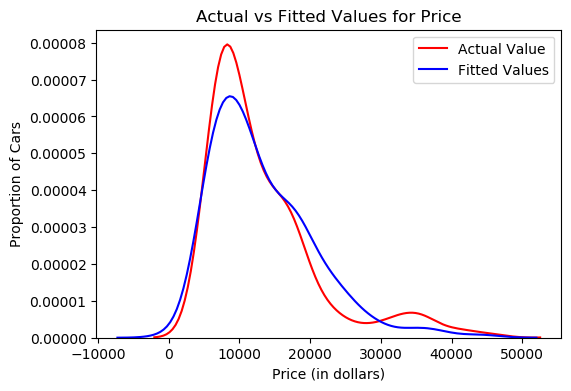

In [58]:
X = df[features]
y = df[target]

lm.fit(X, y)
y_hat = lm.predict(X)

plt.figure(figsize=(6, 4))

ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')

plt.show()

In [59]:
from pandas.io.json import build_table_schema

build_table_schema(df)

{'fields': [{'name': 'index', 'type': 'integer'},
  {'name': 'horsepower', 'type': 'string'},
  {'name': 'curb-weight', 'type': 'integer'},
  {'name': 'engine-size', 'type': 'integer'},
  {'name': 'highway-mpg', 'type': 'integer'},
  {'name': 'price', 'type': 'string'}],
 'primaryKey': ['index'],
 'pandas_version': '0.20.0'}

Let's now revisit the problem and see how we can use ptype to resolve it.

In [60]:
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]

df = pd.read_csv('../data/auto.csv', names = headers, dtype='str')
df = df[features+target]
df.head()

ptype = Ptype()

In [61]:
schema = ptype.fit_schema(df)
ptype.show_schema()

,horsepower,curb-weight,engine-size,highway-mpg,price
type,integer,integer,integer,integer,integer


In [62]:
df = ptype.transform_schema(df, schema)

In [63]:
df.loc[130]

horsepower     <NA>
curb-weight    2579
engine-size     132
highway-mpg      31
price          9295
Name: 130, dtype: Int64

In [64]:
df.dtypes

horsepower     Int64
curb-weight    Int64
engine-size    Int64
highway-mpg    Int64
price          Int64
dtype: object

In [65]:
# check counts of missing data
missing_data = df.isnull().sum()
missing_data.sort_values(inplace=True, ascending=False)
display(missing_data.head())

# drop rows
n = df.shape[0]
df.dropna(subset=["horsepower", "price"], axis=0, inplace=True)
print("# rows deleted = " + str(n-df.shape[0]))

# update the indices
df.reset_index(drop=True, inplace=True)

price          4
horsepower     2
highway-mpg    0
engine-size    0
curb-weight    0
dtype: int64

# rows deleted = 6


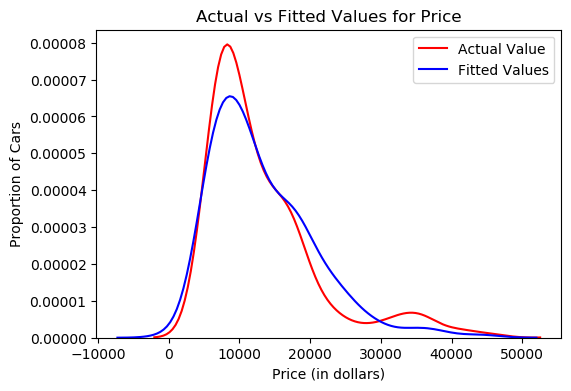

In [66]:
X = df[features]
y = df[target]

lm = LinearRegression()
lm.fit(X, y)
y_hat = lm.predict(X)

plt.figure(figsize=(6, 4))

ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')

plt.show()

# 1. Incorrect Column Type Prediction

## 1.a Incorrect Type Prediction

In [67]:
column2ARFF = Column2ARFF("../models/")

In [68]:
df = read_data(dataset_name="accident2016", header=0)

column = "Time (24hr)"
df_subsample = subsample_df(df, column_to_sample_from=column, sample_num=10)
df_subsample

,Time (24hr)
293,1615
475,1800
67,1157
133,715
350,1110
362,57
160,2104
117,1727
29,1708
402,1910


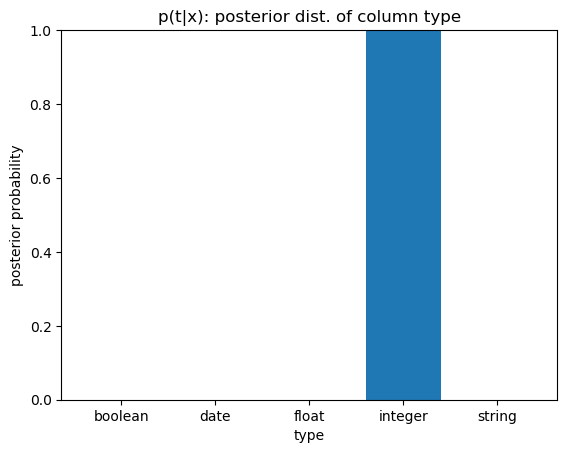

In [69]:
ptype.fit_schema(df_subsample)

plot_column_type_posterior(ptype.cols[column].p_t)

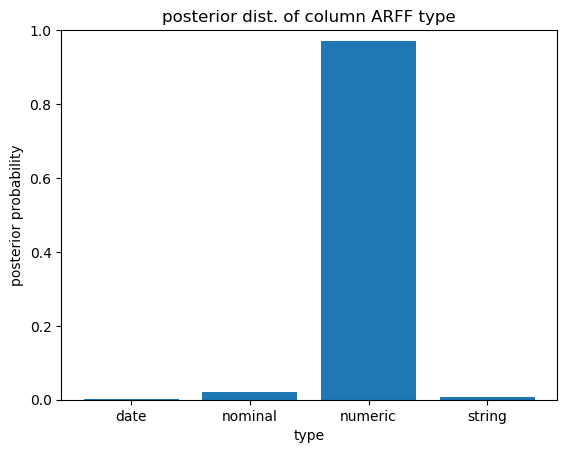

In [70]:
features = ptype.cols[column].features
arff_type, arff_post = column2ARFF.get_arff(features)

plot_arff_type_posterior(arff_post)

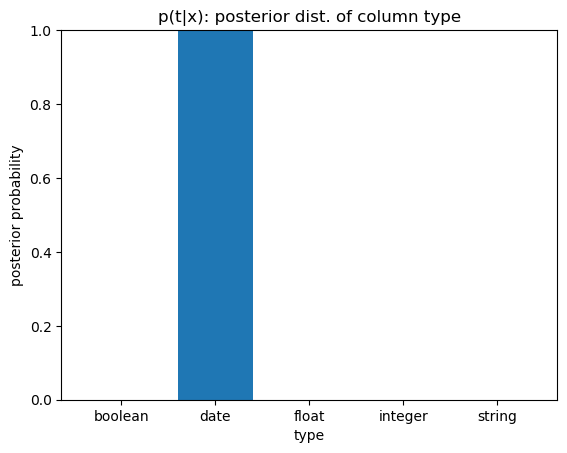

In [71]:
ptype.reclassify_column(column, 'date-iso-8601')

plot_column_type_posterior(ptype.cols[column].p_t)

# do the same thing for arff type

## 1.b Uniform posterior distribution

In [72]:
df = read_data(dataset_name='inspection_outcomes', header=0)

column = 'Provision type'
df_subsample = subsample_df(df, column_to_sample_from = column, sample_num = 10)
df_subsample

,Provision type
37,Children's home
140,Children's home
1090,Children's home
661,Children's home
53,Children's home
330,Children's home
1101,Children's home
1147,Children's home
1281,Children's home
906,Children's home


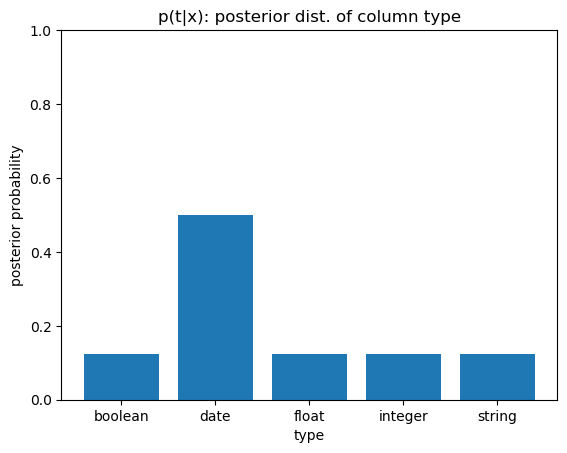

In [73]:
ptype.fit_schema(df_subsample)

plot_column_type_posterior(ptype.cols[column].p_t)

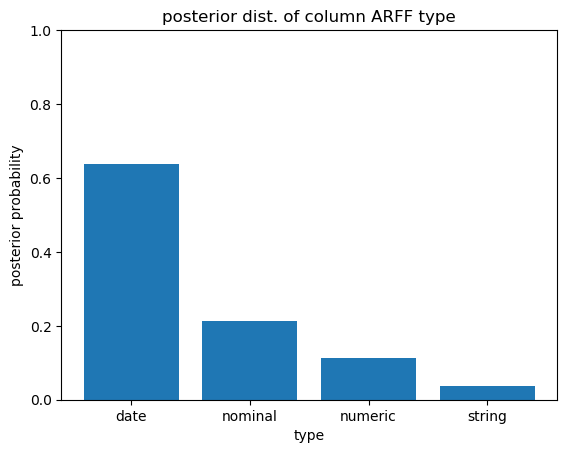

In [74]:
features = ptype.cols[column].features
arff_type, arff_post = column2ARFF.get_arff(features)

plot_arff_type_posterior(arff_post)

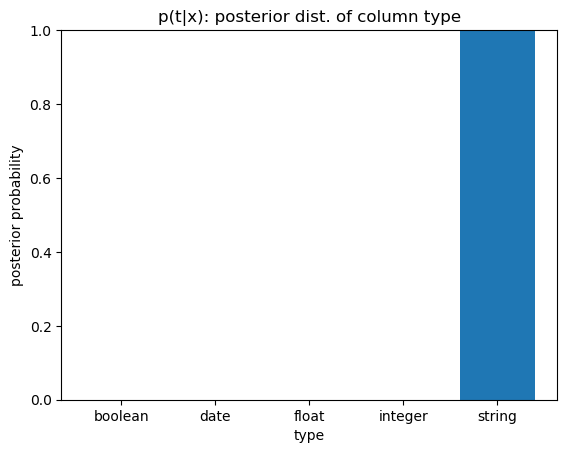

In [75]:
ptype.reclassify_column(column, 'string')

plot_column_type_posterior(ptype.cols[column].p_t)

# do the same thing for arff type
# add the character to the alphabet?